In [3]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


-\|/-\|/-\|/-\|/-\|/-\|/-\-\|/--\|/--\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\


Building jupyterlab assets (production, minimized)


-\|/-\|/-\|/-\|/-\|-\|/-\-\|/--\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/


Building jupyterlab assets (production, minimized)



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time
import copy

import math
import IPython

In [19]:
base_lat = [32, 36]
base_lon = [125, 129]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 25
pivot_time = 5
gridmap_pivot_distance_km = 5

earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490, 
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188, 
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

In [20]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(tlat != gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km - tlat
        elif(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lat.append(grid_lat[-1] + dlat)

        if(vlat <= 0):
            break

collection_grid_lat = [(grid_lat[i]-base_lat[0])*(base_lat[1]-grid_lat[-1])/(grid_lat[-1]-base_lat[0]) for i in range(0, len(grid_lat))]
grid_lat = [x+y for x,y in zip(grid_lat, collection_grid_lat)]

for ilon in range(1, len(absolute_distance_pos[1])):
    vlon = absolute_distance_pos[1][ilon]
    while(True):
        tlon = 0
        if(tlon != gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km - tlon
        elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
        else: tlon = vlon # vlon <= gridmap_pivot_distance_km
            
        vlon -= tlon
        dlon = tlon/lon_distance_per_one[(ilon//5)*5]
            
        grid_lon.append(grid_lon[-1] + dlon)
            
        if(vlon <= 0):
            break

collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/(grid_lon[-1]-base_lon[0]) for i in range(0, len(grid_lon))]
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]
        
print('Grid_latitude len: %d'%(len(grid_lat)))
print('Grid_longitude len: %d'%(len(grid_lon)))

Grid_latitude len: 93
Grid_longitude len: 79


In [21]:
def draw_basemap_grid(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor="none", edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

In [22]:
DATA_DIR = "data/AIS/"
DATA_NAME = 'Dynamic_20200204.csv'
skiprow_count = 3

f = open(DATA_DIR+DATA_NAME, 'r', encoding='cp949')
for i in range(0, skiprow_count):
    line = f.readline()
    if not line: break
    print(line)
f.close()

ais = pd.read_csv(DATA_DIR+DATA_NAME,
                  encoding='cp949', sep='\s+|,', engine='python', 
                  skiprows=range(0, skiprow_count),
                  names=['MMSI','일자', '시간', '위도','경도', 'SOG', 'COG', 'Heading'])
print('Data len in AIS:' + str(len(ais)))
ais.drop(ais[(ais['위도'] < base_lat[0]) | (ais['위도'] > base_lat[1]) | (ais['경도'] < base_lon[0]) | (ais['경도'] > base_lon[1])].index, inplace=True)
print('Data len in Range:' + str(len(ais)))

조회 기간 : 2020-02-04 00:00:00 ~ 2020-02-04 23:59:59

조회선박 척수 : 7850

MMSI,일시,위도,경도,SOG,COG,Heading

Data len in AIS:20653646
Data len in Range:11078235


In [23]:
mmsis = list(set(ais["MMSI"].tolist()))
ais_dict = {}
progress = []
for i in range(0, len(mmsis)):
    per = int((i/len(mmsis))*100)
    if(per%5 == 0 and per not in progress):
        progress.append(per)
        print('Progress rate: %d/%d'%(per, 100))
        
    ais_dict[mmsis[i]] = ais[ais['MMSI'] == mmsis[i]]
print('Progress rate: %d/%d'%(100, 100))

Progress rate: 0/100
Progress rate: 5/100
Progress rate: 10/100
Progress rate: 15/100
Progress rate: 20/100
Progress rate: 25/100
Progress rate: 30/100
Progress rate: 35/100
Progress rate: 40/100
Progress rate: 45/100
Progress rate: 50/100
Progress rate: 55/100
Progress rate: 60/100
Progress rate: 65/100
Progress rate: 70/100
Progress rate: 75/100
Progress rate: 80/100
Progress rate: 85/100
Progress rate: 90/100
Progress rate: 95/100
Progress rate: 100/100


Draw Basemap
Draw Gridmap
Draw AIS data


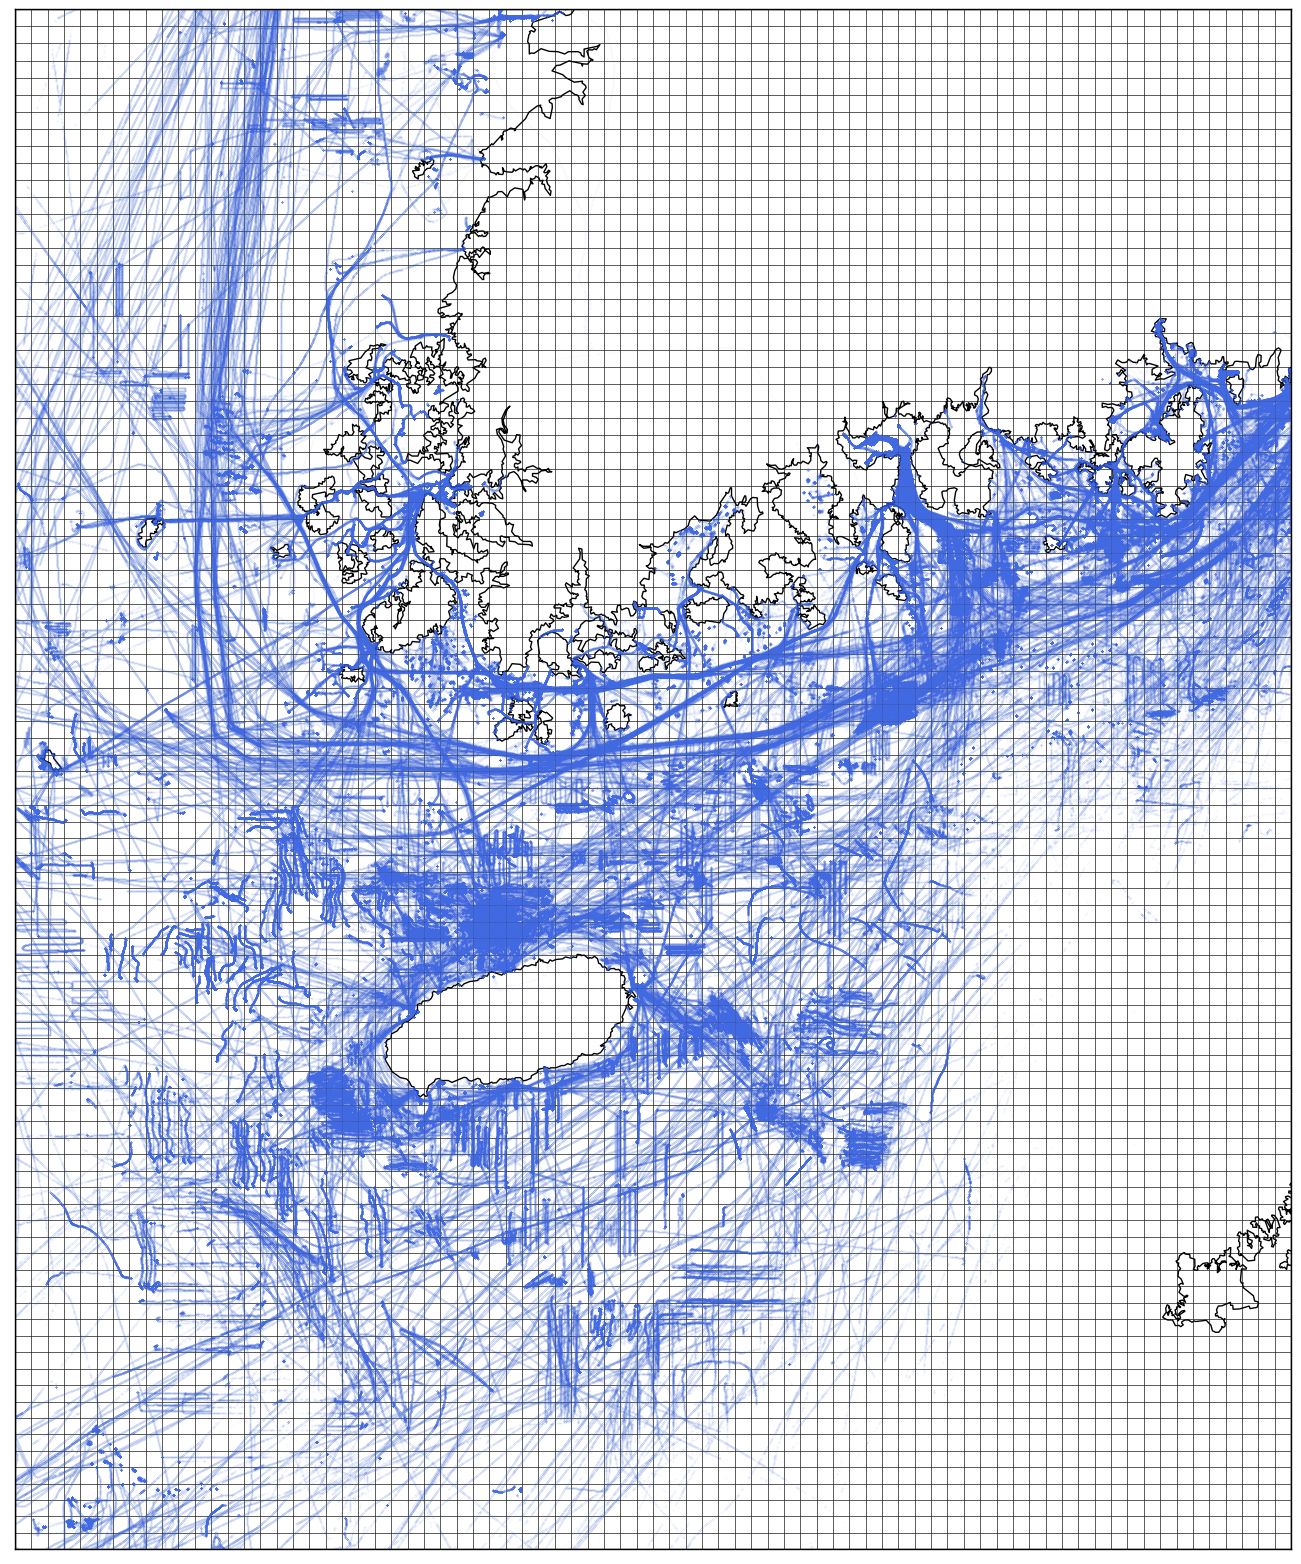

In [24]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = [p, [], '', 0, 0, 0, 0]  # NESW
        
print('Draw AIS data')
ais_lons = ais.경도.tolist()
ais_lats = ais.위도.tolist()

ais_lons, ais_lats = m(ais_lons, ais_lats)
plt.plot(ais_lons, ais_lats, 'o', c='royalblue', alpha=0.1, markersize=0.2)
plt.show()

In [25]:
def find_grid_key(llist, v):
    result = -1
    for i in range(0, len(llist)-1):
        if llist[i] <= v and llist[i+1] >= v:
            return llist[i]
    return result

In [26]:
for mmsi in mmsis:
    pais = ais_dict[mmsi]
    plat = copy.deepcopy(pais.위도.tolist())
    plon = copy.deepcopy(pais.경도.tolist())
    
    klat = plat.pop(0)
    klon = plon.pop(0)
    key = '(%f,%f)'%(find_grid_key(grid_lat, klat), find_grid_key(grid_lon, klon))
    
    while(len(plat) > 0):
        tklat = plat.pop(0)
        tklon = plon.pop(0)
        tkey = '(%f,%f)'%(find_grid_key(grid_lat, tklat), find_grid_key(grid_lon, tklon))
        
        if(key == tkey):
            continue
        if (klat < tklat):
            grid_map[key][3] += 1
        elif (klon < tklon):
            grid_map[key][4] += 1
        elif (klat > tklat):
            grid_map[key][5] += 1
        elif (klon > tklon):
            grid_map[key][6] += 1
            
        klat = tklat
        klon = tklon
        key = '(%f,%f)'%(find_grid_key(grid_lat, klat), find_grid_key(grid_lon, klon))

In [27]:
rkeys = grid_map.keys()
raw_data = {'key' : rkeys,
            'north_weight' : [grid_map[k][3] for k in rkeys],
            'east_weight' : [grid_map[k][4] for k in rkeys],
            'south_weight' : [grid_map[k][5] for k in rkeys],
            'west_weight' : [grid_map[k][6] for k in rkeys],
           }
weight_df = pd.DataFrame(raw_data)

In [28]:
weight_df

,key,north_weight,east_weight,south_weight,west_weight
0,"(32.000000,125.000000)",0,0,0,0
1,"(32.043478,125.000000)",1,0,0,0
2,"(32.086957,125.000000)",2,0,0,0
3,"(32.130435,125.000000)",4,0,2,0
4,"(32.173913,125.000000)",3,0,3,0
...,...,...,...,...,...
7171,"(35.782609,128.948718)",0,0,0,0
7172,"(35.826087,128.948718)",0,0,0,0
7173,"(35.869565,128.948718)",0,0,0,0
7174,"(35.913043,128.948718)",0,0,0,0


In [29]:
dir_path = 'gridmap_weight/'
file_path = 'WEIGHT_%s_D%sLA0%sLA1%sLO0%sLO1%s.csv'%(DATA_NAME.replace('.csv', ''), 
                                                 str(gridmap_pivot_distance_km),
                                                 str(base_lat[0]).replace('.','_'),
                                                 str(base_lat[1]).replace('.','_'),
                                                 str(base_lon[0]).replace('.','_'),
                                                 str(base_lon[1]).replace('.','_'))

In [30]:
file_path

'WEIGHT_Dynamic_20200204_D5LA032LA136LO0125LO1129.csv'

In [31]:
weight_df.to_csv(dir_path+file_path, index=False)

In [32]:
grid_map['(34.869565,127.760097)']

KeyError: '(34.869565,127.760097)'

In [24]:
grid_map.keys()

dict_keys(['(32.000000,124.000000)', '(32.043478,124.000000)', '(32.086957,124.000000)', '(32.130435,124.000000)', '(32.173913,124.000000)', '(32.217391,124.000000)', '(32.260870,124.000000)', '(32.304348,124.000000)', '(32.347826,124.000000)', '(32.391304,124.000000)', '(32.434783,124.000000)', '(32.478261,124.000000)', '(32.521739,124.000000)', '(32.565217,124.000000)', '(32.608696,124.000000)', '(32.652174,124.000000)', '(32.695652,124.000000)', '(32.739130,124.000000)', '(32.782609,124.000000)', '(32.826087,124.000000)', '(32.869565,124.000000)', '(32.913043,124.000000)', '(32.956522,124.000000)', '(33.000000,124.000000)', '(33.043478,124.000000)', '(33.086957,124.000000)', '(33.130435,124.000000)', '(33.173913,124.000000)', '(33.217391,124.000000)', '(33.260870,124.000000)', '(33.304348,124.000000)', '(33.347826,124.000000)', '(33.391304,124.000000)', '(33.434783,124.000000)', '(33.478261,124.000000)', '(33.521739,124.000000)', '(33.565217,124.000000)', '(33.608696,124.000000)', '